#Forescasting de Series de Tiempo con ARIMA


##Analisis Exploratorio

In [ ]:
import pandas as pd
from pandas import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def parser(x):
    return datetime.strptime(x,'%Y-%m')

data = '/content/drive/MyDrive/Data Kaggle/sales-cars.csv'
data = pd.read_csv(data, index_col=0, parse_dates=[0], date_parser=parser)

In [ ]:
data.head()

,Sales
Month,
2016-01-01,266
2016-02-01,146
2016-03-01,183
2016-04-01,119
2016-05-01,180


In [ ]:
data.dtypes

Sales    int64
dtype: object

In [ ]:
data.isnull().sum()

Sales    0
dtype: int64

In [ ]:
data.describe()

,Sales
count,36.00000
mean,295.75000
std,117.81908
min,119.00000
25%,192.50000
50%,280.00000
75%,402.75000
max,520.00000


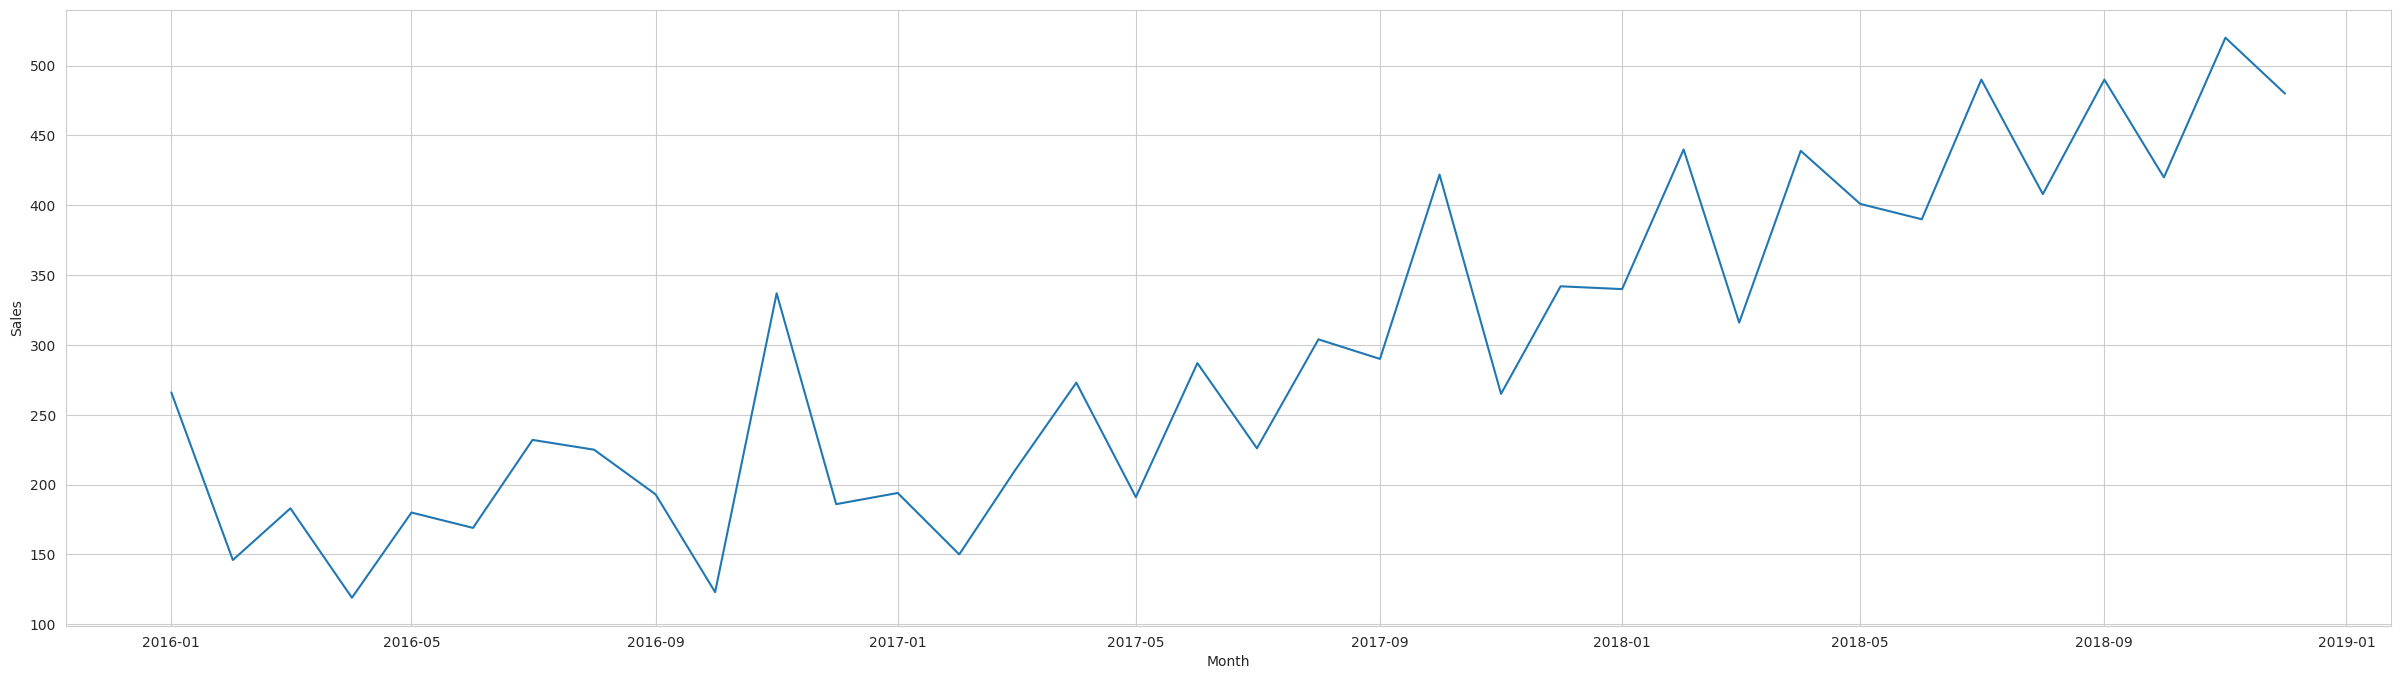

In [ ]:
plt.figure(figsize=(30,8))
sns.set_style("whitegrid")
sns.lineplot(data = data, x= "Month", y="Sales")

In [ ]:
sns.reset_orig()
sns.reset_defaults()
mpl.rcParams.update(mpl.rcParamsDefault)

## Estacionariedad
Estacionariedad media significa que la varianza y covarianza es constante en los diferentes periodos. Aparentemente es no es estacionaria.

In [ ]:
sales_count = len(data.Sales)
sales_count

36

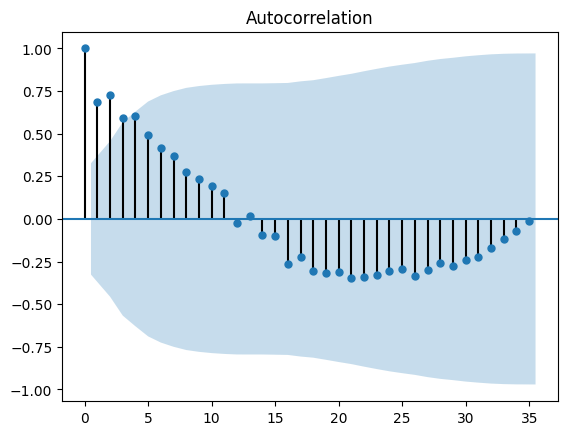

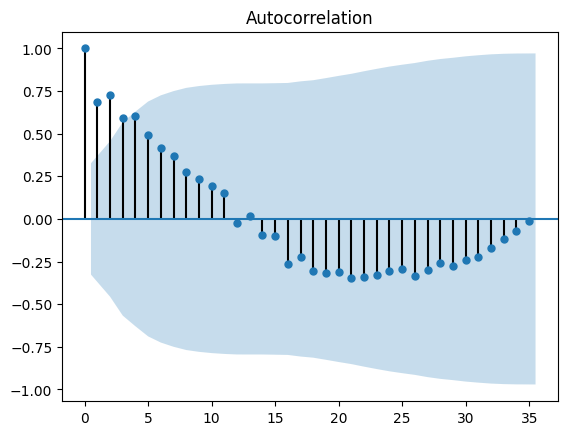

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data, lags=sales_count-1)

La data no es estacionaria.

## Convertir la seria a estacionaria.

In [ ]:
data.shift(1)

,Sales
Month,
2016-01-01,NaN
2016-02-01,266.0
2016-03-01,146.0
2016-04-01,183.0
2016-05-01,119.0
2016-06-01,180.0
2016-07-01,169.0
2016-08-01,232.0
2016-09-01,225.0


In [ ]:
sales_diff = data.diff(periods=1) # integrado de orden 1, dado por d (d de diferencia), uno de los parámetros del modelo ARIMA

In [ ]:
sales_diff = sales_diff[1:]
sales_diff.head()

,Sales
Month,
2016-02-01,-120.0
2016-03-01,37.0
2016-04-01,-64.0
2016-05-01,61.0
2016-06-01,-11.0


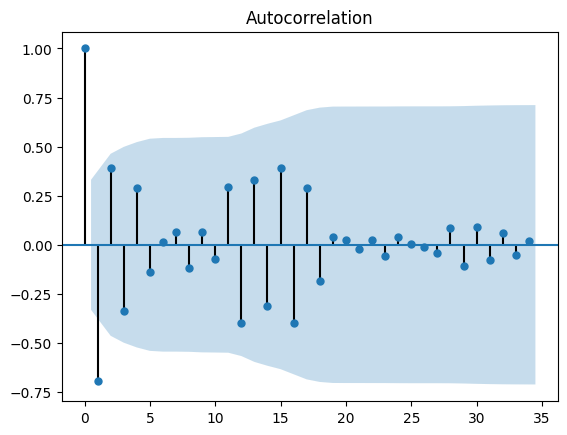

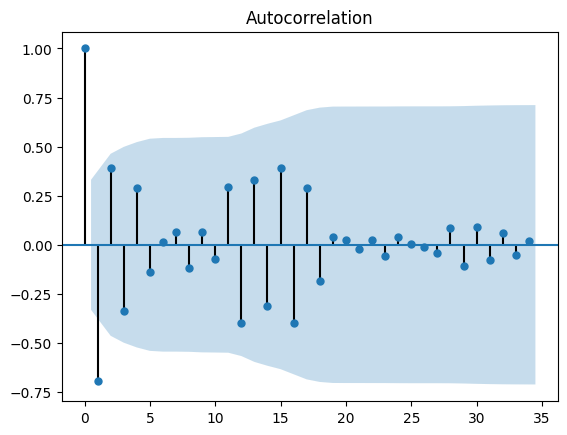

In [ ]:
plot_acf(sales_diff, lags=len(sales_diff)-1)

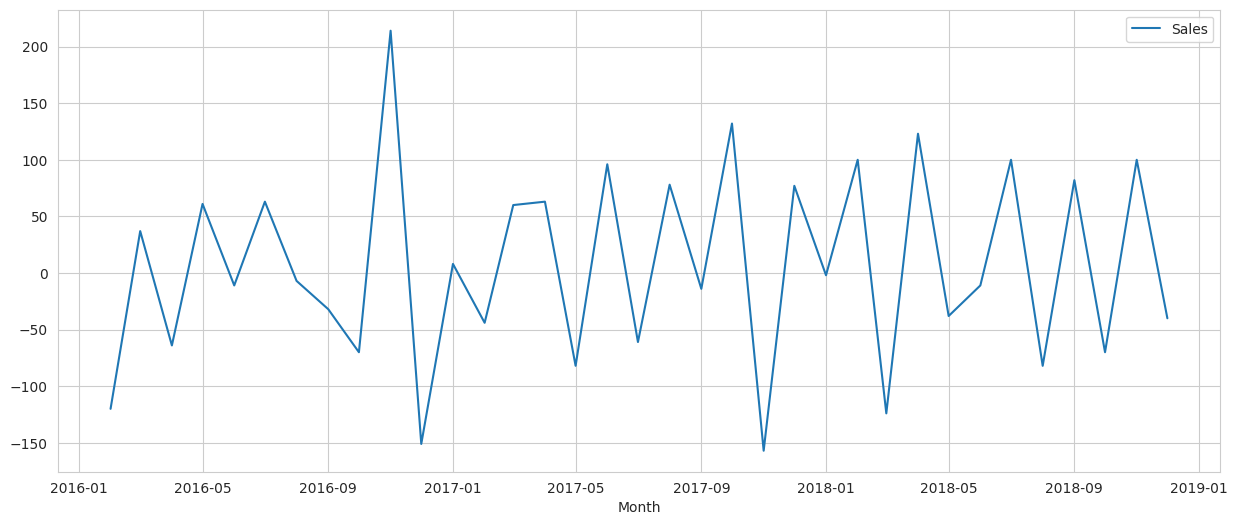

In [ ]:
plt.figure(figsize=(15,6))
sns.set_style("whitegrid")
sns.lineplot(data=sales_diff)

Esta data ya es correcta, para poder construir nuestro modelo, pero con ARIMA, no es necesario hacer esta diferenciación, ya que el parametro d la genera.

## Modelo Autoregresivo AR

In [ ]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

In [ ]:
X = data.values
train = X[0:27] # 27 data como data de entrenamiento
test = X[26:]  # 10 data como data de testeo
predictions = list()

In [ ]:
model_ar = AR(train)
model_ar_fit = model_ar.fit()

In [ ]:
train.size

27

In [ ]:
test.size

10

In [ ]:
predictions = model_ar_fit.predict(start=27,end=len(X))
predictions

array([398.22922886, 368.27242294, 429.47485941, 379.17750391,
       431.35262347, 399.90234723, 433.3589338 , 418.74469463,
       453.45711544, 429.65174489])

In [ ]:
test

array([[316],
       [439],
       [401],
       [390],
       [490],
       [408],
       [490],
       [420],
       [520],
       [480]])

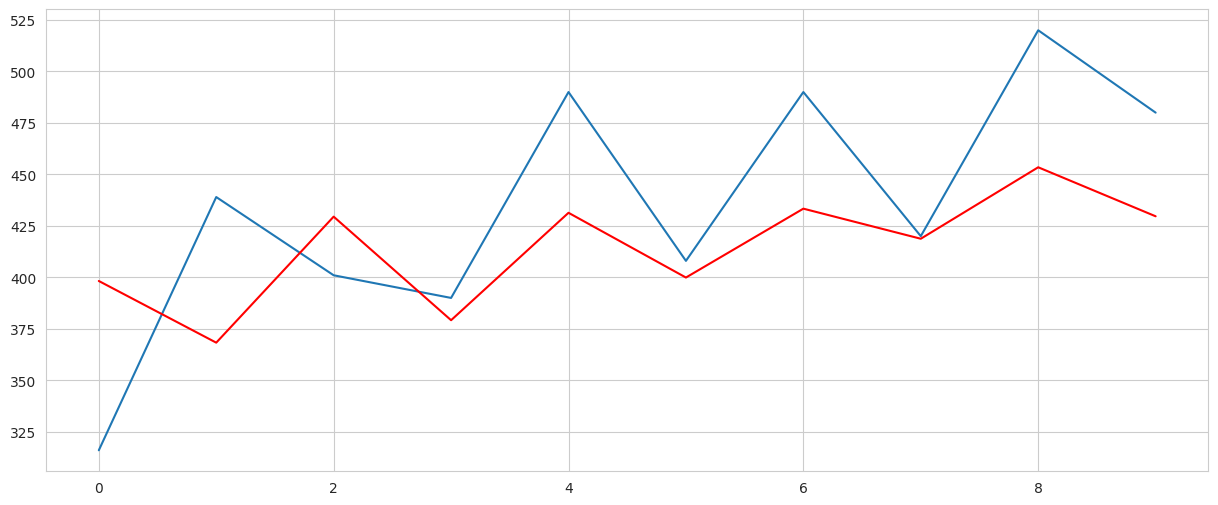

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(test)
plt.plot(predictions,color='red')

In [ ]:
mse = mean_squared_error(test,predictions)
print(f'MSE: {mse}')

MSE: 2636.975548167747


Vemos que no es un modelo muy preciso y simple pero es bueno entenderlo antes de comenar con ARIMA.

## Modelo ARIMA 

In [ ]:
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data Kaggle/sales-cars.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = data.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]

# Predicción
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	history.append(test[t])

In [ ]:
mse = mean_squared_error(test,predictions)
print(f'MSE: {mse}')

MSE: 2769.64108337312


In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
rmse

52.62737959820078

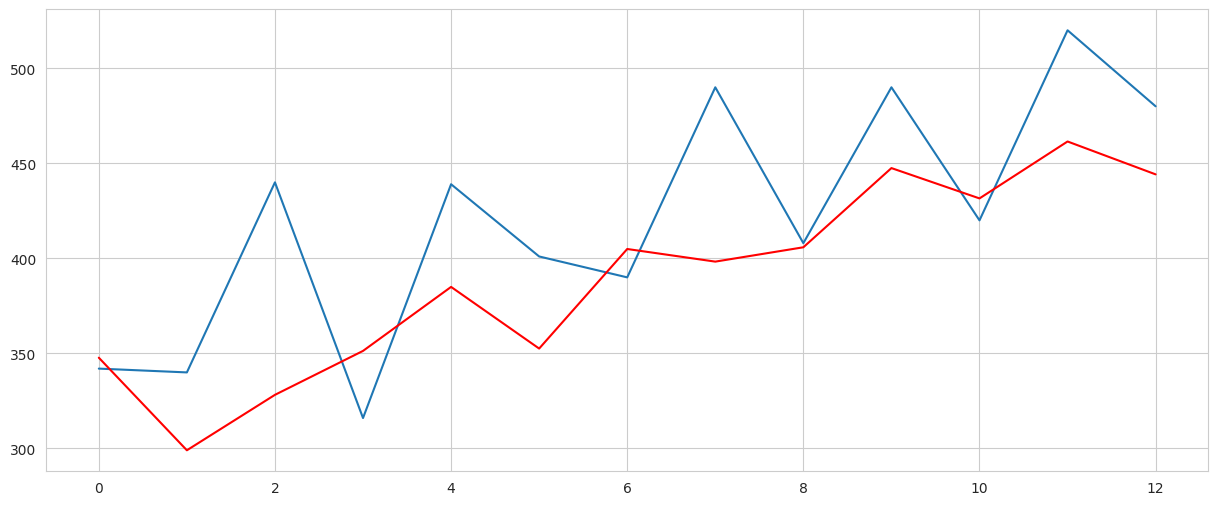

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(test)
plt.plot(predictions,color='red')

Como seleccionar la mejor conbinación pdq:

In [ ]:
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
series = pd.read_csv('/content/drive/MyDrive/Data Kaggle/sales-cars.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=171.357
ARIMA(0, 0, 1) RMSE=142.207
ARIMA(0, 0, 2) RMSE=111.797
ARIMA(0, 1, 0) RMSE=82.252
ARIMA(0, 1, 1) RMSE=63.319
ARIMA(0, 1, 2) RMSE=41.411
ARIMA(0, 2, 0) RMSE=164.826
ARIMA(0, 2, 1) RMSE=83.110
ARIMA(0, 2, 2) RMSE=47.273
ARIMA(1, 0, 0) RMSE=104.838
ARIMA(1, 0, 1) RMSE=72.232
ARIMA(1, 0, 2) RMSE=56.717
ARIMA(1, 1, 0) RMSE=51.996
ARIMA(1, 1, 1) RMSE=51.641
ARIMA(1, 1, 2) RMSE=55.173
ARIMA(1, 2, 0) RMSE=79.249
ARIMA(1, 2, 1) RMSE=49.136
ARIMA(1, 2, 2) RMSE=40.044
ARIMA(2, 0, 0) RMSE=65.731
ARIMA(2, 0, 1) RMSE=65.533
ARIMA(2, 0, 2) RMSE=63.915
ARIMA(2, 1, 0) RMSE=51.512
ARIMA(2, 1, 1) RMSE=52.627
ARIMA(2, 1, 2) RMSE=55.173
ARIMA(2, 2, 0) RMSE=68.302
ARIMA(2, 2, 1) RMSE=47.002
ARIMA(2, 2, 2) RMSE=50.650
ARIMA(4, 0, 0) RMSE=62.904
ARIMA(4, 0, 1) RMSE=63.393
ARIMA(4, 0, 2) RMSE=66.268
ARIMA(4, 1, 0) RMSE=55.660
ARIMA(4, 1, 1) RMSE=47.220
ARIMA(4, 1, 2) RMSE=48.793
ARIMA(4, 2, 0) RMSE=51.271
ARIMA(4, 2, 1) RMSE=41.407
ARIMA(4, 2, 2) RMSE=40.731
ARIMA(6, 0, 0) RMSE=61.

In [ ]:
X = data.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]

# Predicción
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(8,2,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	history.append(test[t])

In [ ]:
mse = mean_squared_error(test,predictions)
print(f'MSE: {mse}')

MSE: 1411.5727468477342


In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
rmse

37.5709029282999

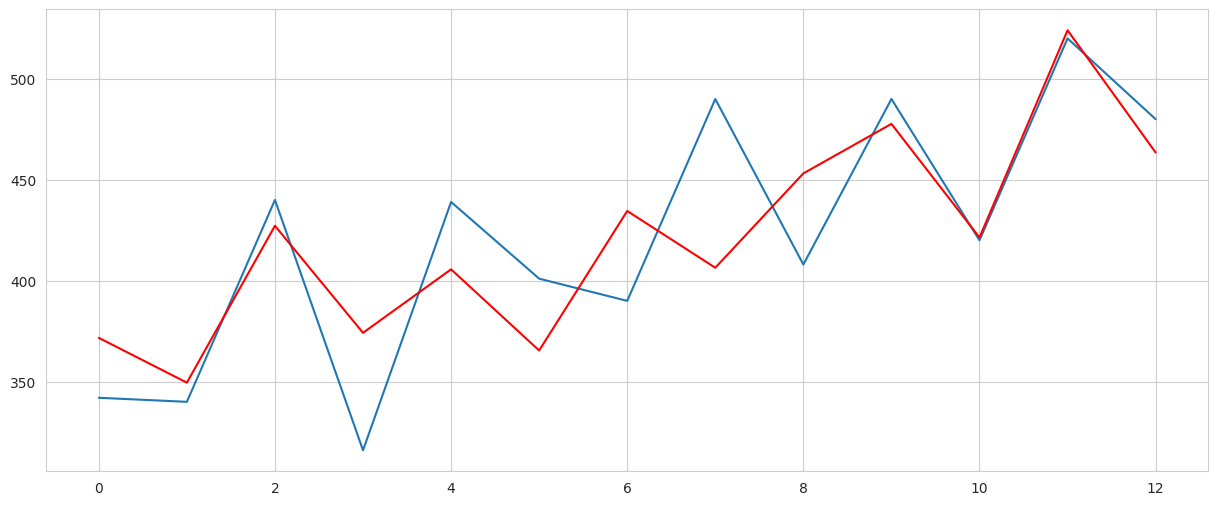

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(test)
plt.plot(predictions,color='red')

Elegimos la combinación pdq que nos de menor RMSE

##Conclusiones
Con ARIMA logramos obtener un modelo de Forecasting de venta de autos con un RMSE 37.57. Tambien vimos como optimizar los valores p, d, q con el fin de poder obtener un mejor modelo.